In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('..')
from dataset import batcher

In [100]:
MODEL_DIR = '../saved_models/'
LR_RATE = 0.0001
OPT = tf.keras.optimizers.Adam(learning_rate=LR_RATE)
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [110]:
# Get test split
# bands = ['BLUE', 'GREEN', 'RED', 'NIR', 'SW_IR1', 'SW_IR2', 'TEMP', 'VIIRS', 'DELTA_TEMP', 'CO']
bands = ['VIIRS']
test_batcher = batcher.Batcher(bands, country_year="ethiopia-2018", bucket=False, shuffle=False, split='test', repeat=1, batch_size=3000).get_dataset()
x_true = []
y_true = []
for x, y in test_batcher:
    x_true.append(x)
    y_true.append(y)

print(np.shape(x_true))

(1, 652, 224, 224, 1)


In [111]:
# Load model
experiments = ['imagery_sample_cnn_regression_NL']

def load_model_from_dir(model_name):
    model_path = MODEL_DIR + model_name + '.h5'
    model = tf.keras.models.load_model(model_path, compile=False)
    
    return model

In [112]:
# Get consumption predictions
trained_model = load_model_from_dir(experiments[0])
trained_model.compile(
            loss=LOSS,
            optimizer=OPT,
            metrics=METRICS,
        )

y_preds = trained_model.predict_on_batch(x_true)
print(y_preds)

2023-02-22 17:11:35.709092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


[[-1.48850737e+01]
 [-1.52651606e+01]
 [ 1.18269002e+00]
 [-1.42868567e+01]
 [-1.55922489e+01]
 [-3.03882420e-01]
 [-1.43167839e+01]
 [-1.48115511e+01]
 [-1.38279371e+01]
 [-2.56295490e+00]
 [-1.43608713e+01]
 [-1.40425701e+01]
 [-1.36094084e+01]
 [-1.45230570e+01]
 [-1.45534277e+01]
 [-5.45736885e+00]
 [ 4.57448244e-01]
 [-1.38917198e+01]
 [-1.42001143e+01]
 [-1.41576805e+01]
 [-1.39842529e+01]
 [-1.41690264e+01]
 [ 1.47455215e-01]
 [-1.46017456e+01]
 [ 2.02661846e-02]
 [-1.39527006e+01]
 [ 1.34404182e+00]
 [ 1.97769016e-01]
 [-1.55041857e+01]
 [-1.52435484e+01]
 [-5.26680136e+00]
 [-1.45710707e+01]
 [-1.17459497e+01]
 [-1.34982939e+01]
 [-1.44907312e+01]
 [-1.41748838e+01]
 [-1.51930017e+01]
 [-1.42023029e+01]
 [-1.48105106e+01]
 [-1.04321585e+01]
 [-6.02459574e+00]
 [ 1.97769016e-01]
 [-1.51140766e+01]
 [-4.25077629e+00]
 [-1.43114319e+01]
 [-5.05610466e+00]
 [-1.39832172e+01]
 [-1.44693289e+01]
 [ 5.74880600e-01]
 [ 2.43866324e-01]
 [-6.12784195e+00]
 [-1.45378561e+01]
 [-1.5234731

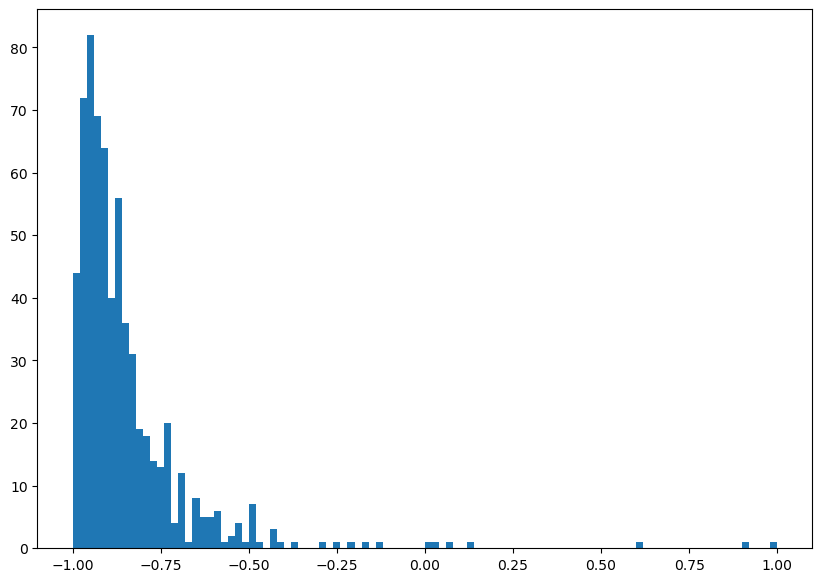

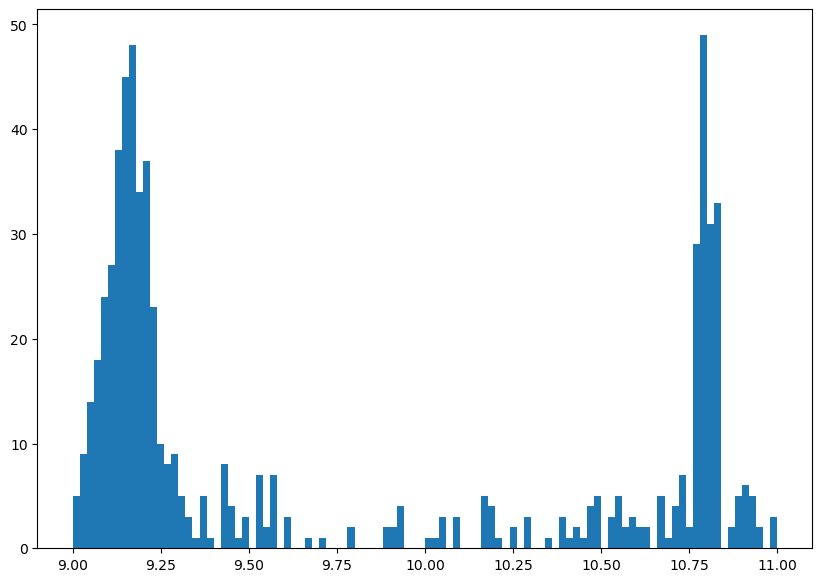

In [116]:
# Find r-squared
y_true = np.squeeze(y_true)
y_preds = np.squeeze(y_preds)
y_preds = y_preds + 10

# Plot histograms
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_true, bins = 100)
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(y_preds, bins = 100)
plt.show()

y_true = 2 * ((y_true - min(y_true)) / (max(y_true) - min(y_true))) - 1
y_preds =2 * ((y_preds - min(y_preds)) / (max(y_preds) - min(y_preds))) - 1

r2 = pearsonr(y_true, y_preds)[0]

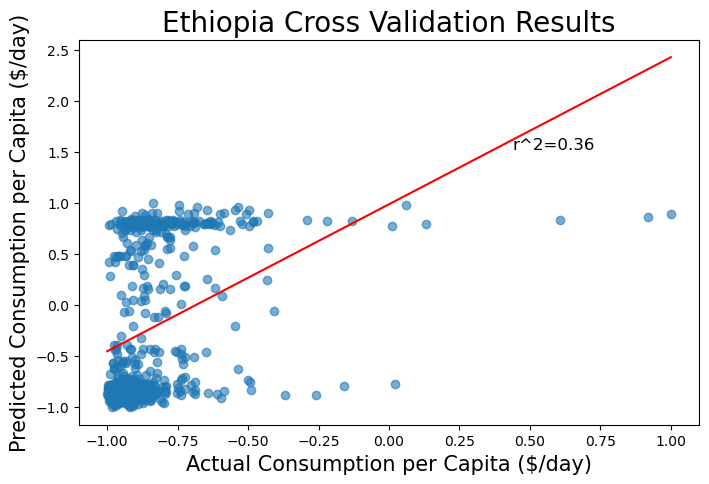

In [117]:
# Plot predictions
country = 'Ethiopia'
fig = plt.figure(figsize=(8,5))
plt.scatter(y_true, y_preds, alpha=0.6)
plt.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true, y_preds, 1))(np.unique(y_true)), color='red')
plt.text(0.5, 0.5, f'r^2={round(r2, 2)}', ha='left', va='top', size=12, transform=ax.transAxes)
plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
plt.title(f'{country} Cross Validation Results', fontsize=20)
# plt.xlim([np.min(y_true), 10])
# plt.ylim([-2, np.max(y_preds)])
plt.show()